In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.optimize import differential_evolution

In [105]:
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("csv_output/p1730_2022.csv", converters={
    "AmplKSM": eval, "hSM": eval, "nTrackSMX": eval, "nTrackSMY": eval, "nTrackSM": eval,
    "hSM0": eval, "nTrackSMX0": eval, "nTrackSMY0": eval, "nTrackSM0": eval,
    "EdepCntSCT": eval, "EdepDetNE": eval, "TimDetNE": eval, "EdepStNE": eval, "TimStNE": eval
})

In [65]:
df.head(4)

,N_event,NRUN,NEVENT,PART0,E0,Teta,Fi,XAxisShift,YAxisShift,H1INT,...,hSM0,nTrackSMX0,nTrackSMY0,nTrackSM0,EdepCntSCT,EdepDetNE,TimDetNE,EdepStNE,TimStNE,marker
0,0.0,173000.0,1.0,14.0,100000000.0,30.0,53.163406,21.254372,60.104460,3549455.5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[484.4850158691406, 516.8804321289062, 411.3...","[[[[136352.890625, 136258.109375, 136239.4375,...","[[1755.4146728515625, 1280.5128173828125, 975....","[[[136375.296875, 136243.75, 136237.4375, 1362...",-1.0
1,0.0,173001.0,1.0,14.0,100000000.0,30.0,118.852844,0.967100,53.281273,1595547.5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[1688.9930419921875, 1648.3756103515625, 143...","[[[[61049.18359375, 60952.125, 60910.125, 6092...","[[6706.82470703125, 5095.81103515625, 3485.858...","[[[63138.34765625, 60913.1015625, 60909.011718...",-1.0
2,0.0,173002.0,1.0,14.0,100000000.0,30.0,286.241000,-19.320170,46.458084,2439109.5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[1179.007080078125, 1364.9500732421875, 1572...","[[[[93722.7109375, 93293.046875, 93289.6015625...","[[5341.71337890625, 4321.70556640625, 2836.470...","[[[104192.484375, 93290.578125, 93289.4296875,...",-1.0
3,0.0,173003.0,1.0,14.0,100000000.0,30.0,65.182830,40.142555,39.634895,1626964.9,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[1088.6395263671875, 1051.98583984375, 1205....","[[[[63131.47265625, 62198.55078125, 62169.4257...","[[4219.66259765625, 2415.139892578125, 2878.16...","[[[63131.47265625, 62172.51171875, 62168.00781...",-1.0


In [ ]:
coordinates_df = pd.read_csv('../data/coordinates.csv')
coordinates_df.head(2)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
1,1,1.2,-37.609,5.885,-6.684


## положение оси $X_0, Y_0$ 
$$
X_0 = \frac{\sum X_i \cdot m_i}{m_i}
$$

$$
Y_0 = \frac{\sum Y_i \cdot m_i}{m_i} 
$$

In [119]:
df['NeNKGlong'].head(5)

0     4734297.0
1    15149074.0
2     6574410.0
3    18120796.0
4    11086829.0
Name: NeNKGlong, dtype: float64

In [120]:
df['sNKGlong'].head(5)

0    1.375637
1    1.288089
2    1.355909
3    1.252712
4    1.309551
Name: sNKGlong, dtype: float64

In [288]:
E_1_event = df['EdepStNE'].iloc[2]
theta = df['Teta'].iloc[2]
phi = df['Fi'].iloc[2]
X = coordinates_df['X']
Y = coordinates_df['Y']
Z = coordinates_df['Z']

In [289]:
e_list = []
for i_cluster, cluster in enumerate(E_1_event):
    for j_station, value in enumerate(cluster):
        e_list.append(
            {'cluster': i_cluster+1, 'station': j_station+1, 'E': value})

E_stations = pd.DataFrame(e_list)
E_stations.head(2)

,cluster,station,E
0,1,1,5341.713379
1,1,2,4321.705566


In [290]:
X0 = np.sum(X * E_stations['E']) / np.sum(E_stations['E'])
Y0 = np.sum(Y * E_stations['E']) / np.sum(E_stations['E'])

In [291]:
print(X0, Y0)

-17.629012437333696 43.18054600377378


In [292]:
Z0 = -18

## $r$
Ось ШАЛ:

$
 \begin{cases}
X = X_0 + ct \cos{\phi}\sin{\theta} \\
Y = Y_0 + ct \sin{\phi}\sin{\theta} \\
Z = Z_0 + ct \cos{\theta}
 \end{cases}
$

Пусть станция имеет координаты $(X_s,Y_s,Z_s)$

$
r = \frac{|\vec{v} \times (P - P_0)|}{|\vec{v}|}
$

$ P_0​=(X_0​,Y_0​,Z_0​) $ — точка на оси ШАЛ

$ P = (X_s,Y_s,Z_s) $ — координаты станции

$ \vec{v}=(\cos⁡{\phi}\sin{\theta},\sin⁡{\phi}\sin⁡{\theta}, \cos⁡{\theta})$ — направляющий вектор оси ШАЛ


In [293]:
def compute_r(X0, Y0, Z0, theta, phi, coordinates_df):
    theta = np.radians(theta)
    phi = np.radians(phi)

    v = np.array([np.cos(phi) * np.sin(theta), np.sin(phi)
                 * np.sin(theta), np.cos(theta)])

    P0 = np.array([X0, Y0, Z0])

    P = np.vstack(
        (coordinates_df['X'], coordinates_df['Y'], coordinates_df['Z'])).T

    cross_product = np.cross(P - P0, v)

    r = np.linalg.norm(cross_product, axis=1) / np.linalg.norm(v)

    return r

In [294]:
r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)

## $\rho$

$ N_e = \frac{E}{8.2 \text{MeV}} $

$ S = 0.8 \times 0.8 \times 4 $ 

$ \rho = \frac{N_e}{S} $


In [295]:
N_e = E_stations['E'] / 8.2
S = 0.8 * 0.8 * 4
rho = N_e/S

In [296]:
rho_log = np.log10(rho)

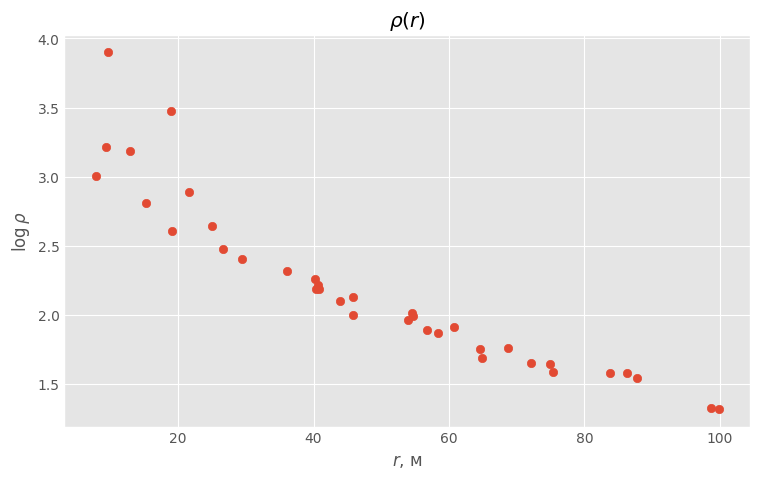

In [297]:
plt.figure(figsize=(7, 4))
plt.scatter(r, rho_log)
plt.xscale("linear")
# plt.yscale("log")
plt.xlabel(r'$r$, м')
plt.ylabel(r'$\log{\rho}$')
plt.title(r'$\rho(r)$')
plt.show()

## функция пространственного распределения электронов

$ \rho(r) = \frac{N_e}{2\pi r_m^2} (\frac{r}{r_m})^{s-2}(1+\frac{r}{r_m})^{s-4.5} \frac{\Gamma(4.5-s)}{\Gamma(s)\Gamma(4.5-2s)}$

$ r_m = 79$

In [298]:
def rho_model(r, Ne, s, r_m=78):
    term1 = Ne / (2 * np.pi * r_m**2)
    term2 = (r / r_m) ** (s - 2)
    term3 = (1 + r / r_m) ** (s - 4.5)
    term4 = gamma(4.5 - s) / (gamma(s) * gamma(4.5 - 2 * s))
    return term1 * term2 * term3 * term4

In [299]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    X0, Y0, Ne, s = params
    r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)
    rho_calc = rho_model(r, Ne, s)
    return np.mean((rho_calc - rho) ** 2)

In [300]:
# Начальные приближения параметров
initial_params = [0, 0, 1e5, 2]  # X0, Y0, Ne, s
bounds = [
    (-100, 100),
    (-100, 100),
    (1, 1e10),
    (1, 5)
]  # Границы для оптимизации

In [301]:
result = minimize(loss_function, initial_params, args=(
    coordinates_df, rho, theta, phi, Z0), bounds=bounds, method="Nelder-Mead")

In [302]:
result = differential_evolution(loss_function, bounds, args=(
    coordinates_df, rho, theta, phi, Z0))

In [303]:
X0_opt, Y0_opt, Ne_opt, s_opt = result.x
print(
    f"Оптимальные параметры: X0={X0_opt}, Y0={Y0_opt}, Ne={Ne_opt}, s={s_opt}")

Оптимальные параметры: X0=-22.87467880559937, Y0=56.614062535968614, Ne=7666060.745751411, s=1.1278371815481711


In [304]:
print(np.min(r))

7.834419739757524


In [305]:
print(np.min(r_opt))

2.2330642112157295


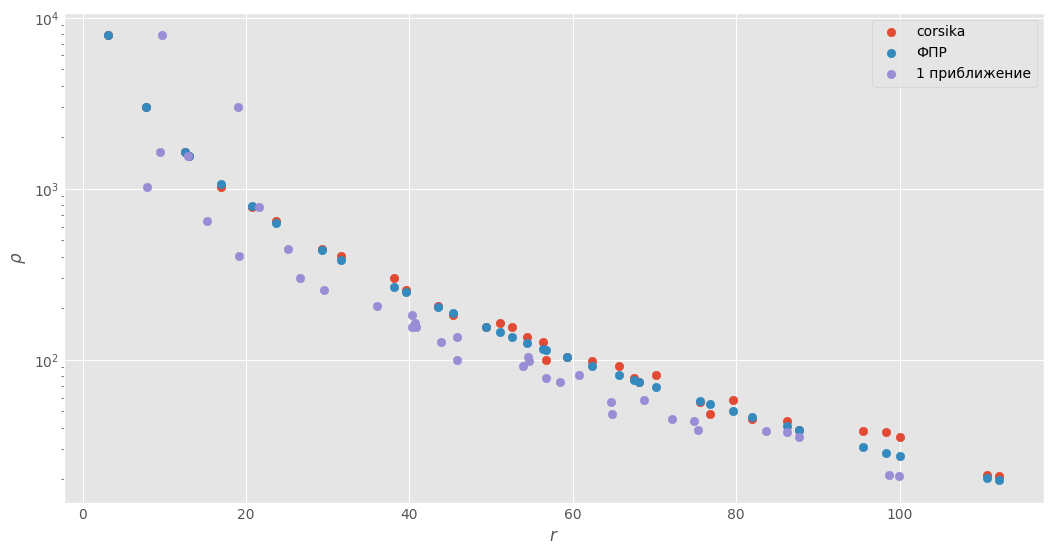

In [307]:
r_opt = compute_r(X0_opt, Y0_opt, Z0, theta, phi, coordinates_df)
rho_fit = rho_model(r_opt, Ne_opt, s_opt)

plt.figure(figsize=(10, 5))
plt.scatter(r_opt, rho, label="corsika")
plt.scatter(r_opt, rho_fit, label="ФПР")
plt.scatter(r, rho, label="1 приближение")
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()